# Neural Networks: Training with Backpropagation

## Recap: Forward Propagation

In the previous notebook (**16_neural_network_intro.ipynb**), we learned:
- The structure of a 2-layer neural network
- How forward propagation computes predictions
- The role of weights, biases, and activation functions

However, with randomly initialized weights, our predictions are essentially random! 
We need a way to **learn** the right weights from data.

## The Training Problem

**Goal**: Find weights and biases that minimize the difference between predictions and true labels.

**Process**:
1. **Measure error**: Use a loss function to quantify how wrong our predictions are
2. **Compute gradients**: Use backpropagation to calculate how each parameter affects the loss
3. **Update parameters**: Use gradient descent to adjust parameters in the direction that reduces loss
4. **Repeat**: Iterate until the loss converges to a minimum


In [1]:
# Import required libraries
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Data Preparation

We'll use the same breast cancer dataset and preprocessing as in the previous notebook.


In [2]:
# Load and prepare the data
data = pd.read_csv(
    "https://raw.githubusercontent.com/changyaochen/MECE4520/master/"
    "data/breast_cancer.csv"
)
data["label"] = data["diagnosis"].apply(lambda x: 0 if x == "B" else 1)

# Select features
features = [
    "radius_mean",
    "texture_mean",
    "perimeter_mean",
    "area_mean",
    "smoothness_mean",
    "compactness_mean",
    "concavity_mean",
    "concave_mean",
    "symmetry_mean",
    "fractal_mean",
]

# Train-test split
X_raw, X_raw_test, y, y_test = train_test_split(
    data[features].values,
    data["label"].values,
    test_size=0.2,
    random_state=42
)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
X_test = scaler.transform(X_raw_test)

# Reshape labels
y = y.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

print(f"Training data: X={X.shape}, y={y.shape}")
print(f"Test data: X_test={X_test.shape}, y_test={y_test.shape}")


Training data: X=(455, 10), y=(455, 1)
Test data: X_test=(114, 10), y_test=(114, 1)


## Helper Functions

Let's (re-)define the sigmoid activation function and the forward propagation function from the previous notebook.


In [3]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """Computes the sigmoid activation function.

    Args:
        z: Input array of any shape.

    Returns:
        Array of same shape as z with sigmoid applied element-wise.
    """
    return 1.0 / (1 + np.exp(-z))


def forward_propagation(
    X: np.ndarray,
    W_1: np.ndarray,
    b_1: np.ndarray,
    W_2: np.ndarray,
    b_2: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Performs forward propagation through a 2-layer neural network.

    Args:
        X: Input data of shape (n_samples, n_features).
        W_1: Weight matrix for layer 1 of shape (n_hidden, n_features).
        b_1: Bias vector for layer 1 of shape (n_hidden, 1).
        W_2: Weight matrix for layer 2 of shape (1, n_hidden).
        b_2: Bias scalar for layer 2 of shape (1, 1).

    Returns:
        Tuple containing:
            - A_2: Final output predictions of shape (n_samples, 1).
            - Z_2: Pre-activation values for layer 2 of shape (n_samples, 1).
            - A_1: Activations from layer 1 of shape (n_samples, n_hidden).
            - Z_1: Pre-activation values for layer 1 of shape (n_samples, n_hidden).
    """
    # Layer 1: Hidden layer
    Z_1 = X @ W_1.T
    A_1 = sigmoid(Z_1 + b_1.T)

    # Layer 2: Output layer
    Z_2 = A_1 @ W_2.T
    A_2 = sigmoid(Z_2 + b_2.T)

    return A_2, Z_2, A_1, Z_1


## Backpropagation Theory

### The Loss Function

For binary classification, we use **binary cross-entropy loss** (also called log-loss):

$$
L = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i) \right],
$$

where $n$ is the number of samples, $y_i \in \{0, 1\}$ is the true label, and $\hat{y}_i$ is the predicted probability. This loss:
- Is always positive
- Equals 0 when predictions perfectly match labels
- Increases as predictions diverge from labels
- Works well with sigmoid activation

### The Chain Rule

Backpropagation uses the **chain rule** from calculus to compute how the loss changes with respect to each parameter. For a composed function $ f(g(x)) $, the chain rule states:

$$
\frac{df}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx}
$$

In our network, information flows: **Input → Layer 1 → Layer 2 → Output → Loss**

To find how the loss changes with parameters in Layer 1, we need to propagate derivatives backward through Layer 2, Layer 1, and so on.

### Gradient Descent

Once we have gradients (derivatives of loss with respect to parameters), we update parameters using:

$$
\theta_{new} = \theta_{old} - \alpha \frac{\partial L}{\partial \theta}
$$

where $ \alpha $ is the **learning rate** (step size). The negative sign means we move in the direction that reduces the loss.


## Backpropagation Implementation

Now let's implement backpropagation to compute all the gradients. The key insight is to work **backward** from the output to the input.

### Gradient Equations (for our 2-layer network with sigmoid activation):

**Output layer (Layer 2):**
- $ \frac{\partial L}{\partial Z^{[2]}} = \hat{Y} - Y $  (derivative of cross-entropy + sigmoid)
- $ \frac{\partial L}{\partial W^{[2]}} = \frac{1}{n} \frac{\partial L}{\partial Z^{[2]}}^T A^{[1]} $
- $ \frac{\partial L}{\partial b^{[2]}} = \frac{1}{n} \text{mean}(\frac{\partial L}{\partial Z^{[2]}}) $

**Hidden layer (Layer 1):**
- $ \frac{\partial L}{\partial Z^{[1]}} = (\frac{\partial L}{\partial Z^{[2]}} W^{[2]}) \odot A^{[1]} \odot (1 - A^{[1]}) $  (chain rule + sigmoid derivative)
- $ \frac{\partial L}{\partial W^{[1]}} = \frac{1}{n} \frac{\partial L}{\partial Z^{[1]}}^T X $
- $ \frac{\partial L}{\partial b_1} = \frac{1}{n} \text{mean}(\frac{\partial L}{\partial Z_1}) $

where $ \odot $ denotes element-wise multiplication, and $\text{mean}$ denotes the mean across all samples.


In [4]:
def compute_gradients_backprop(
    X: np.ndarray,
    y: np.ndarray,
    W_1: np.ndarray,
    b_1: np.ndarray,
    W_2: np.ndarray,
    b_2: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, float]:
    """Computes gradients using backpropagation for a 2-layer network.

    Applies the chain rule to compute how the loss changes with respect to
    each parameter. Uses binary cross-entropy loss for binary classification.

    Args:
        X: Input data of shape (n_samples, n_features).
        y: True labels of shape (n_samples, 1).
        W_1: Weight matrix for layer 1 of shape (n_hidden, n_features).
        b_1: Bias vector for layer 1 of shape (n_hidden, 1).
        W_2: Weight matrix for layer 2 of shape (1, n_hidden).
        b_2: Bias scalar for layer 2 of shape (1, 1).

    Returns:
        Tuple containing:
            - dW_2: Gradient for W_2 of shape (1, n_hidden).
            - db_2: Gradient for b_2 of shape (1, 1).
            - dW_1: Gradient for W_1 of shape (n_hidden, n_features).
            - db_1: Gradient for b_1 of shape (n_hidden, 1).
            - loss: Current loss value (scalar).
            - y_hat: Predicted probabilities of shape (n_samples, 1).
    """
    # Forward propagation to get predictions and intermediate values
    y_hat, Z_2, A_1, Z_1 = forward_propagation(X=X, W_1=W_1, b_1=b_1, W_2=W_2, b_2=b_2)
    n = len(y_hat)

    # Compute binary cross-entropy loss
    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    y_hat_clipped = np.clip(y_hat, epsilon, 1 - epsilon)
    loss = -np.mean(
        y * np.log(y_hat_clipped) + (1 - y) * np.log(1 - y_hat_clipped)
    )  # this is a scalar

    # Backpropagation: Layer 2 (Output Layer)
    # Derivative of loss with respect to Z_2 (combining cross-entropy + sigmoid)
    dZ_2 = y_hat - y  # Shape: (n_samples, 1)

    # Gradients for W_2 and b_2
    dW_2 = (dZ_2.T @ A_1) / n  # Shape: (1, n_hidden) = (1, n_samples) @ (n_samples, n_hidden)
    db_2 = np.mean(dZ_2.T, axis=1, keepdims=True)  # Shape: (1, 1) - mean across n_samples

    # Backpropagation: Layer 1 (Hidden Layer)
    # Apply chain rule: derivative flows through W_2 and through sigmoid
    # Sigmoid derivative: σ'(z) = σ(z) * (1 - σ(z)) = A_1 * (1 - A_1)
    dZ_1 = (dZ_2 @ W_2) * A_1 * (1 - A_1)  # Shape: (n_samples, n_hidden) = (n_samples, 1) @ (1, n_hidden) * element-wise multiplication

    # Gradients for W_1 and b_1
    dW_1 = (dZ_1.T @ X) / n  # Shape: (n_hidden, n_features) = (n_hidden, n_samples) @ (n_samples, n_features)
    db_1 = np.mean(dZ_1.T, axis=1, keepdims=True)  # Shape: (n_hidden, 1) - mean across n_samples

    return dW_2, db_2, dW_1, db_1, loss, y_hat

### Testing Backpropagation

Let's verify that our backpropagation implementation works by computing gradients with random initial parameters.


In [5]:
# Initialize random parameters
np.random.seed(42)
W_1_init = np.random.normal(size=(3, X.shape[1]))
b_1_init = np.random.normal(size=(3, 1))
W_2_init = np.random.normal(size=(1, 3))
b_2_init = np.random.normal(size=(1, 1))

# Compute gradients
dW_2, db_2, dW_1, db_1, initial_loss, _ = compute_gradients_backprop(
    X=X, y=y, W_1=W_1_init, b_1=b_1_init, W_2=W_2_init, b_2=b_2_init
)

print("Backpropagation Results:")
print(f"Initial loss: {initial_loss:.4f}")
print(f"\nGradient shapes:")
print(f"  dW_2: {dW_2.shape}, db_2: {db_2.shape}")
print(f"  dW_1: {dW_1.shape}, db_1: {db_1.shape}")
print(f"\nSample gradient values:")
print(f"  dW_2 mean: {np.mean(np.abs(dW_2)):.6f}")
print(f"  dW_1 mean: {np.mean(np.abs(dW_1)):.6f}")


Backpropagation Results:
Initial loss: 0.8953

Gradient shapes:
  dW_2: (1, 3), db_2: (1, 1)
  dW_1: (3, 10), db_1: (3, 1)

Sample gradient values:
  dW_2 mean: 0.169068
  dW_1 mean: 0.028499


## Training with Gradient Descent

Now we'll implement the complete training loop that:
1. Computes gradients using backpropagation
2. Updates parameters in the direction that reduces loss
3. Repeats until convergence

### Convergence Criteria

We stop training when the change in loss becomes smaller than a threshold (`epsilon`), indicating we've reached a (local) minimum.


In [6]:
def train_neural_network(
    X: np.ndarray,
    y: np.ndarray,
    W_1_init: np.ndarray,
    b_1_init: np.ndarray,
    W_2_init: np.ndarray,
    b_2_init: np.ndarray,
    learning_rate: float = 0.01,
    epsilon: float = 1e-6,
    max_iterations: int = 10000,
    verbose: bool = False,
    report_interval: int = 10,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, list, list]:
    """Trains a 2-layer neural network using gradient descent.

    Iteratively computes gradients via backpropagation and updates parameters
    to minimize the binary cross-entropy loss. Stops when loss converges or
    maximum iterations is reached.

    Args:
        X: Training data of shape (n_samples, n_features).
        y: Training labels of shape (n_samples, 1).
        W_1_init: Initial weights for layer 1 of shape (n_hidden, n_features).
        b_1_init: Initial biases for layer 1 of shape (n_hidden, 1).
        W_2_init: Initial weights for layer 2 of shape (1, n_hidden).
        b_2_init: Initial biases for layer 2 of shape (1, 1).
        learning_rate: Step size for gradient descent updates.
        epsilon: Convergence threshold for change in loss.
        max_iterations: Maximum number of training iterations.
        verbose: If True, prints progress every 100 iterations.
        report_interval: How often to report progress.
    Returns:
        Tuple containing:
            - W_1: Trained weights for layer 1.
            - b_1: Trained biases for layer 1.
            - W_2: Trained weights for layer 2.
            - b_2: Trained biases for layer 2.
            - losses: List of loss values at each iteration.
            - roc_auc_scores: List of ROC-AUC scores at each iteration.
    """
    # Initialize parameters
    W_1 = W_1_init.copy()
    b_1 = b_1_init.copy()
    W_2 = W_2_init.copy()
    b_2 = b_2_init.copy()

    # Track metrics
    losses = [float("inf")]
    roc_auc_scores = [0.5]

    iteration = 0
    diff_in_loss = float("inf")

    while abs(diff_in_loss) > epsilon and iteration < max_iterations:
        iteration += 1

        # Compute gradients using backpropagation
        dW_2, db_2, dW_1, db_1, loss, y_hat = compute_gradients_backprop(
            X=X, y=y, W_1=W_1, b_1=b_1, W_2=W_2, b_2=b_2
        )
        # Compute ROC-AUC score
        roc_auc = roc_auc_score(y_true=y, y_score=y_hat)
        roc_auc_scores.append(roc_auc)

        # Update parameters using gradient descent
        W_1 -= learning_rate * dW_1
        b_1 -= learning_rate * db_1
        W_2 -= learning_rate * dW_2
        b_2 -= learning_rate * db_2

        # Track loss
        losses.append(loss)
        diff_in_loss = losses[-1] - losses[-2]

        # Print progress
        if verbose and iteration % report_interval == 0:
            print(f"Iteration {iteration:4d}: Loss = {loss:.6f}, ROC-AUC = {roc_auc:.6f}")

    if verbose:
        print(f"\nTraining completed after {iteration} iterations")
        print(f"Final loss: {losses[-1]:.6f}")
        print(f"Final ROC-AUC: {roc_auc_scores[-1]:.6f}")

    return W_1, b_1, W_2, b_2, losses[1:], roc_auc_scores[1:]


### Training the Network

Let's train our 2-layer network on the breast cancer data!


In [7]:
# Train the network
W_1, b_1, W_2, b_2, losses, roc_auc_scores = train_neural_network(
    X=X,
    y=y,
    W_1_init=W_1_init,
    b_1_init=b_1_init,
    W_2_init=W_2_init,
    b_2_init=b_2_init,
    learning_rate=0.1,
    epsilon=1e-3,
    max_iterations=10000,
    verbose=True,
)


Iteration   10: Loss = 0.783356, ROC-AUC = 0.119212
Iteration   20: Loss = 0.691930, ROC-AUC = 0.358733
Iteration   30: Loss = 0.622183, ROC-AUC = 0.748603
Iteration   40: Loss = 0.566772, ROC-AUC = 0.881905
Iteration   50: Loss = 0.521559, ROC-AUC = 0.927008
Iteration   60: Loss = 0.483996, ROC-AUC = 0.943746
Iteration   70: Loss = 0.452375, ROC-AUC = 0.954897
Iteration   80: Loss = 0.425470, ROC-AUC = 0.960338
Iteration   90: Loss = 0.402362, ROC-AUC = 0.964125
Iteration  100: Loss = 0.382349, ROC-AUC = 0.966318
Iteration  110: Loss = 0.364884, ROC-AUC = 0.967973
Iteration  120: Loss = 0.349533, ROC-AUC = 0.969338
Iteration  130: Loss = 0.335955, ROC-AUC = 0.970849
Iteration  140: Loss = 0.323876, ROC-AUC = 0.971366
Iteration  150: Loss = 0.313073, ROC-AUC = 0.972069

Training completed after 153 iterations
Final loss: 0.310054
Final ROC-AUC: 0.972380


### Visualizing Training Progress

Let's plot how the loss and ROC-AUC score evolved during training.


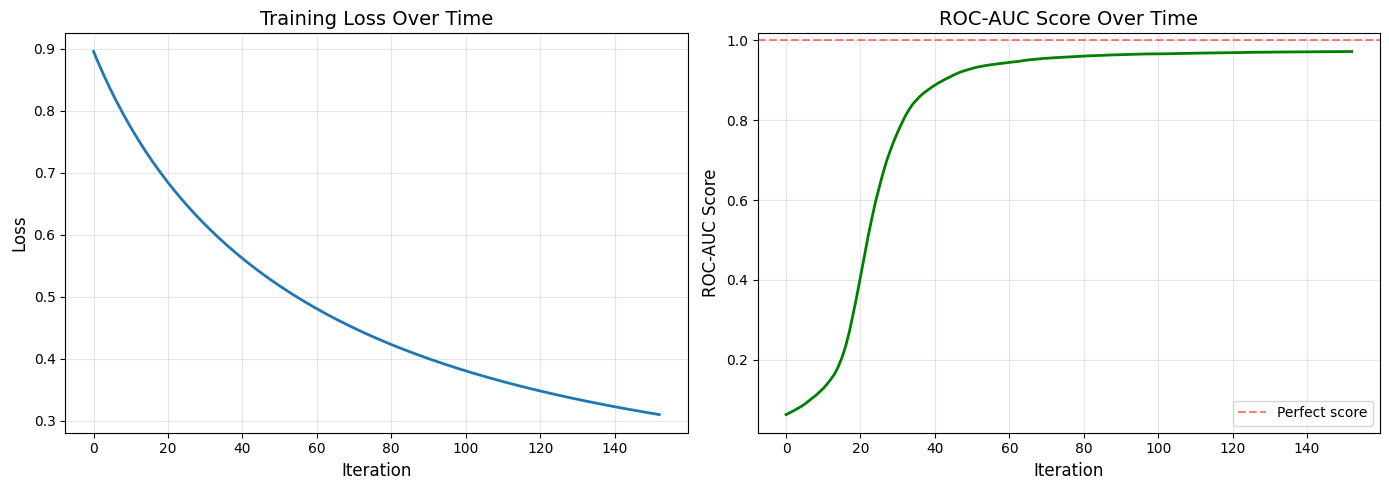

Loss decreased from 0.8953 to 0.3101
ROC-AUC improved from 0.0623 to 0.9724


In [8]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(losses, linewidth=2)
axes[0].set_xlabel("Iteration", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].set_title("Training Loss Over Time", fontsize=14)
axes[0].grid(True, alpha=0.3)

# ROC-AUC curve
axes[1].plot(roc_auc_scores, linewidth=2, color="green")
axes[1].set_xlabel("Iteration", fontsize=12)
axes[1].set_ylabel("ROC-AUC Score", fontsize=12)
axes[1].set_title("ROC-AUC Score Over Time", fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=1.0, color="r", linestyle="--", alpha=0.5, label="Perfect score")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Loss decreased from {losses[0]:.4f} to {losses[-1]:.4f}")
print(f"ROC-AUC improved from {roc_auc_scores[0]:.4f} to {roc_auc_scores[-1]:.4f}")


### Evaluating on Test Data

The real test of our model is how well it performs on unseen data!


In [9]:
# Evaluate on test set
y_test_hat, _, _, _ = forward_propagation(
    X=X_test, W_1=W_1, b_1=b_1, W_2=W_2, b_2=b_2
)
test_roc_auc = roc_auc_score(y_true=y_test, y_score=y_test_hat)

print(f"Test Set Performance:")
print(f"  ROC-AUC Score: {test_roc_auc:.4f}")
print(f"\nThis indicates {'excellent' if test_roc_auc > 0.95 else 'good' if test_roc_auc > 0.85 else 'moderate'} performance!")

# Compare train vs test
print(f"\nTrain ROC-AUC: {roc_auc_scores[-1]:.4f}")
print(f"Test ROC-AUC:  {test_roc_auc:.4f}")
print(f"Difference:    {abs(roc_auc_scores[-1] - test_roc_auc):.4f}")


Test Set Performance:
  ROC-AUC Score: 0.9905

This indicates excellent performance!

Train ROC-AUC: 0.9724
Test ROC-AUC:  0.9905
Difference:    0.0181


## Building the Same Network in PyTorch

While implementing neural networks from scratch is educational, modern deep learning frameworks like **PyTorch** make it much easier to build, train, and deploy neural networks.

### Why PyTorch?

- **Automatic differentiation**: No need to manually derive and code backpropagation
- **GPU acceleration**: Easily train on GPUs for faster computation
- **Rich ecosystem**: Pre-built layers, optimizers, and tools
- **Industry standard**: Widely used in research and production

Let's rebuild our 2-layer network using PyTorch!


In [10]:
# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


### Defining the Neural Network Architecture

In PyTorch, we define a network by subclassing `nn.Module` and specifying the layers in `__init__` and the forward pass in `forward`.


In [11]:
class TwoLayerNN(nn.Module):
    """A 2-layer neural network for binary classification.

    Architecture:
        Input -> Hidden Layer (3 neurons, sigmoid) -> Output Layer (1 neuron, sigmoid)
    """

    def __init__(self, input_size: int, hidden_size: int):
        """Initializes the network layers.

        Args:
            input_size: Number of input features.
            hidden_size: Number of neurons in the hidden layer.
        """
        super(TwoLayerNN, self).__init__()

        # Define layers
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Performs forward propagation.

        Args:
            x: Input tensor of shape (batch_size, input_size).

        Returns:
            Output predictions of shape (batch_size, 1).
        """
        # Hidden layer: linear transformation + sigmoid activation
        hidden_out = self.sigmoid(self.hidden(x))

        # Output layer: linear transformation + sigmoid activation
        output = self.sigmoid(self.output(hidden_out))

        return output


# Create the model
input_size = X.shape[1]  # 10 features
hidden_size = 3  # 3 hidden neurons

model = TwoLayerNN(input_size=input_size, hidden_size=hidden_size).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")


TwoLayerNN(
  (hidden): Linear(in_features=10, out_features=3, bias=True)
  (output): Linear(in_features=3, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 37


### Preparing Data for PyTorch

PyTorch works with tensors (similar to NumPy arrays). We'll convert our data and create data loaders for batch processing.


In [12]:
# Convert NumPy arrays to PyTorch tensors
# We want to ensure all the data is on the same device (CPU or GPU)
X_train_tensor = torch.FloatTensor(X).to(device)
y_train_tensor = torch.FloatTensor(y).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Create datasets and data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Training batches: {len(train_loader)}")
print(f"Batch size: 32")
print(f"Samples per epoch: {len(train_dataset)}")


Training batches: 15
Batch size: 32
Samples per epoch: 455


### Training the PyTorch Model

We need to define:
1. **Loss function**: Binary cross-entropy loss
2. **Optimizer**: SGD (Stochastic Gradient Descent) or Adam
3. **Training loop**: Forward pass → compute loss → backward pass → update weights


In [13]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss - measures how wrong predictions are
optimizer = optim.SGD(model.parameters(), lr=0.1)  # Stochastic Gradient Descent with learning rate 0.1

# Training loop
num_epochs = 100
pytorch_losses = []
pytorch_roc_auc_scores = []

print("Training PyTorch model...")
for epoch in range(num_epochs):
    # Set model to training mode (enables dropout, batch norm, etc. if present)
    model.train()
    epoch_loss = 0.0

    # Iterate over batches
    for batch_X, batch_y in train_loader:
        # Zero the gradients from previous iteration
        # PyTorch accumulates gradients, so we must clear them each batch
        optimizer.zero_grad()

        # Forward pass: compute predictions
        # batch_X shape: (batch_size, n_features)
        # predictions shape: (batch_size, 1)
        predictions = model(batch_X)

        # Compute loss: compares predictions to true labels (batch_y)
        loss = criterion(predictions, batch_y)

        # Backward pass: compute gradients
        # PyTorch automatically computes ∂Loss/∂W and ∂Loss/∂b for all parameters
        # This is the "magic" of automatic differentiation!
        loss.backward()

        # Update weights: W_new = W_old - learning_rate * gradient
        # Optimizer applies gradient descent to all model parameters
        optimizer.step()

        # Accumulate loss for this batch (for monitoring)
        epoch_loss += loss.item()

    # Average loss across all batches in this epoch
    avg_loss = epoch_loss / len(train_loader)
    pytorch_losses.append(avg_loss)

    # Evaluate model performance on full training set
    # Set to evaluation mode (disables dropout, etc.)
    model.eval()

    # Disable gradient computation for evaluation (faster, uses less memory)
    with torch.no_grad():
        # Get predictions for entire training set
        train_predictions = model(X_train_tensor)

        # Compute ROC-AUC score
        # .cpu().numpy() converts PyTorch tensor to NumPy array
        # (sklearn expects NumPy arrays, not PyTorch tensors)
        train_roc_auc = roc_auc_score(
            y_train_tensor.cpu().numpy(),
            train_predictions.cpu().numpy()
        )
        pytorch_roc_auc_scores.append(train_roc_auc)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs}: Loss = {avg_loss:.6f}, ROC-AUC = {train_roc_auc:.6f}")

print(f"\nTraining completed!")
print(f"Final loss: {pytorch_losses[-1]:.6f}")
print(f"Final ROC-AUC: {pytorch_roc_auc_scores[-1]:.6f}")

Training PyTorch model...
Epoch  10/100: Loss = 0.375098, ROC-AUC = 0.975897
Epoch  20/100: Loss = 0.238789, ROC-AUC = 0.979931
Epoch  30/100: Loss = 0.190727, ROC-AUC = 0.981504
Epoch  40/100: Loss = 0.171742, ROC-AUC = 0.982704
Epoch  50/100: Loss = 0.172103, ROC-AUC = 0.983159
Epoch  60/100: Loss = 0.171807, ROC-AUC = 0.983676
Epoch  70/100: Loss = 0.160703, ROC-AUC = 0.983862
Epoch  80/100: Loss = 0.154371, ROC-AUC = 0.984276
Epoch  90/100: Loss = 0.149706, ROC-AUC = 0.984462
Epoch 100/100: Loss = 0.145717, ROC-AUC = 0.984628

Training completed!
Final loss: 0.145717
Final ROC-AUC: 0.984628


### Evaluating the PyTorch Model


In [14]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    y_test_pred_pytorch = model(X_test_tensor)
    test_roc_auc_pytorch = roc_auc_score(
        y_test_tensor.cpu().numpy(),
        y_test_pred_pytorch.cpu().numpy()
    )

print(f"PyTorch Model - Test Set Performance:")
print(f"  ROC-AUC Score: {test_roc_auc_pytorch:.4f}")


PyTorch Model - Test Set Performance:
  ROC-AUC Score: 0.9941


### Comparing Manual Implementation vs PyTorch

Let's visualize and compare the training curves from both approaches.


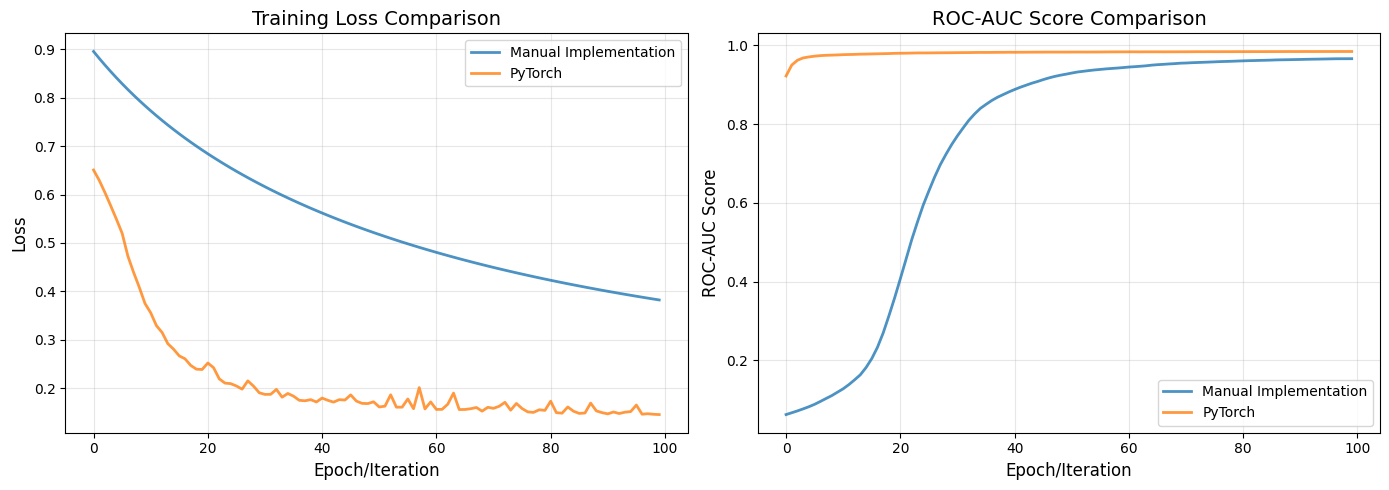


Final Comparison:
Method                    Test ROC-AUC   
Manual Implementation     0.9905
PyTorch                   0.9941


In [15]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss comparison
axes[0].plot(losses[:100], label="Manual Implementation", linewidth=2, alpha=0.8)
axes[0].plot(pytorch_losses, label="PyTorch", linewidth=2, alpha=0.8)
axes[0].set_xlabel("Epoch/Iteration", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].set_title("Training Loss Comparison", fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ROC-AUC comparison
axes[1].plot(roc_auc_scores[:100], label="Manual Implementation", linewidth=2, alpha=0.8)
axes[1].plot(pytorch_roc_auc_scores, label="PyTorch", linewidth=2, alpha=0.8)
axes[1].set_xlabel("Epoch/Iteration", fontsize=12)
axes[1].set_ylabel("ROC-AUC Score", fontsize=12)
axes[1].set_title("ROC-AUC Score Comparison", fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison
print("\nFinal Comparison:")
print(f"{'Method':<25} {'Test ROC-AUC':<15}")
print("=" * 40)
print(f"{'Manual Implementation':<25} {test_roc_auc:.4f}")
print(f"{'PyTorch':<25} {test_roc_auc_pytorch:.4f}")


## MNIST: Where Neural Networks Wins (easily)

While the breast cancer dataset showed that neural networks can match logistic regression's performance, it didn't demonstrate why deep learning is revolutionary. The breast cancer dataset has:
- Only ~600 samples
- 30 carefully **engineered features**
- Relatively linear relationships

Let's now use [**MNIST**](https://en.wikipedia.org/wiki/MNIST_database) (handwritten digit images) to show where neural networks truly excel:
- ~70,000 samples
- 784 **raw pixel values** (28×28 images)
- Complex spatial patterns that require feature learning

We'll compare three approaches:
1. **Logistic Regression**: Baseline linear model
2. **Feedforward Neural Network**: Deep learning with fully connected layers
3. **Convolutional Neural Network (CNN)**: Specialized architecture for images

This will clearly demonstrate the sizable accuracy improvement that neural networks provide for image data!


### Loading and Exploring MNIST Data

MNIST contains 70,000 grayscale images of handwritten digits (0-9):
- 60,000 training images
- 10,000 test images
- Each image is 28×28 pixels (784 features when flattened)


Computing dataset statistics...
Computed MNIST mean: 0.1307
Computed MNIST std:  0.3081
(Standard values are mean=0.1307, std=0.3081)

Training set size: 60000
Test set size: 10000
Image shape: torch.Size([1, 28, 28])


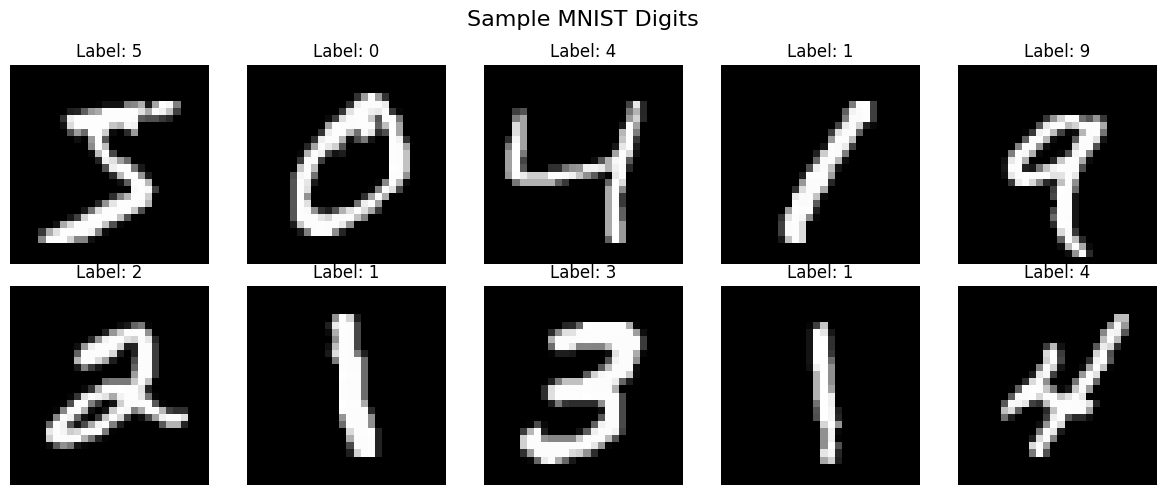

In [16]:
# Import necessary libraries for MNIST
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Step 1: Load MNIST without normalization to compute statistics
print("Computing dataset statistics...")
mnist_train_raw = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()  # Converts PIL Image to tensor, shape: (1, 28, 28)
)

# Compute mean and std from training set
# Accumulate pixel values from all images
all_pixels = []
for image, _ in mnist_train_raw:  # image shape: (1, 28, 28)
    all_pixels.append(image)

# Stack all images and compute statistics
train_data = torch.stack(all_pixels)  # Shape: (60000, 1, 28, 28)
mnist_mean = train_data.mean().item()  # Mean across all 60000*28*28 pixels
mnist_std = train_data.std().item()    # Std across all 60000*28*28 pixels

print(f"Computed MNIST mean: {mnist_mean:.4f}")
print(f"Computed MNIST std:  {mnist_std:.4f}")
print(f"(Standard values are mean=0.1307, std=0.3081)\n")

# Step 2: Now create the proper transform with computed statistics
transform = transforms.Compose([
    transforms.ToTensor(),  # shape: (1, 28, 28)
    transforms.Normalize((mnist_mean,), (mnist_std,))  # Normalize: (x - mean) / std
])

# Load training and test datasets with normalization
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

print(f"Training set size: {len(mnist_train)}")
print(f"Test set size: {len(mnist_test)}")
# First [0] is to fetch the first sample, as (image, label) tuple. Each image: (1, 28, 28) = (channels, height, width)
print(f"Image shape: {mnist_train[0][0].shape}")

# Visualize some sample digits
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image, label = mnist_train[i]  # image shape: (1, 28, 28)
    # Convert from tensor to numpy and denormalize for visualization
    image = image.squeeze().numpy() * mnist_std + mnist_mean  # squeeze: (1, 28, 28) -> (28, 28)
    ax.imshow(image, cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.suptitle("Sample MNIST Digits", fontsize=16)
plt.tight_layout()
plt.show()

In [17]:
# Create DataLoaders for batch processing
batch_size = 128

mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(mnist_train_loader)}")
print(f"Number of test batches: {len(mnist_test_loader)}")


Number of training batches: 469
Number of test batches: 79


### Model 1: Logistic Regression (Baseline)

Logistic regression treats each pixel as an independent feature. It learns a linear combination of pixel values to predict the digit class.

**Architecture**: Input (784) → Output (10 classes)

**Limitations**:
- No hidden layers = no feature learning
- Treats all pixels independently (ignores spatial structure)
- Can only learn linear decision boundaries


In [18]:
class LogisticRegression(nn.Module):
    """Simple logistic regression model - just one linear layer."""

    def __init__(self, input_size=784, num_classes=10):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        # Flatten the image
        x = x.view(x.size(0), -1)  # (batch_size, 28*28)
        return self.linear(x)

# Create model
logistic_model = LogisticRegression().to(device)
print(f"Logistic Regression Parameters: {sum(p.numel() for p in logistic_model.parameters())}")
print(logistic_model)


Logistic Regression Parameters: 7850
LogisticRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [19]:
def train_mnist_model(model, train_loader, test_loader, epochs=10, lr=0.001, model_name="Model", device="cpu"):
    """Trains a PyTorch model using mini-batch gradient descent.

    Performs training loop with forward pass, loss computation, backpropagation,
    and parameter updates. Evaluates on test set after each epoch.

    Args:
        model: PyTorch nn.Module to train.
        train_loader: DataLoader for training data.
        test_loader: DataLoader for test data.
        epochs: Number of complete passes through training data.
        lr: Learning rate for optimizer.
        model_name: Name for progress printing.

    Returns:
        Tuple containing:
            - train_losses: List of average training loss per epoch.
            - train_accuracies: List of training accuracy per epoch.
            - test_accuracies: List of test accuracy per epoch.
    """
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Multi-class classification loss
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer (adaptive learning rate)

    # Initialize tracking lists
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # ========== TRAINING PHASE ==========
        model.train()  # Set to training mode (enables dropout, batch norm updates, etc.)
        running_loss = 0.0
        correct_count = 0
        total_count = 0

        # Process data in batches
        for images, labels in train_loader:
            # Move data to device (CPU or GPU)
            images, labels = images.to(device), labels.to(device)
            # images shape: (batch_size, 1, 28, 28)
            # labels shape: (batch_size,)

            # Step 1: Zero gradients from previous iteration
            # PyTorch accumulates gradients, so we must clear them
            optimizer.zero_grad()

            # Step 2: Forward pass - compute predictions
            outputs = model(images)  # Shape: (batch_size, num_classes)

            # Step 3: Compute loss
            loss = criterion(outputs, labels)  # Scalar value

            # Step 4: Backward pass - compute gradients
            # Automatically computes ∂Loss/∂W for all parameters
            loss.backward()

            # Step 5: Update parameters
            # W_new = W_old - lr * gradient
            optimizer.step()

            # Track statistics for monitoring
            running_loss += loss.item()  # Accumulate batch loss
            _, predicted = torch.max(outputs.data, 1)  # Get class with highest probability
            total_count += labels.size(0)  # Count total samples
            correct_count += (predicted == labels).sum().item()  # Count correct predictions

        # Compute epoch statistics
        train_loss = running_loss / len(train_loader)  # Average loss across batches
        train_acc = 100 * correct_count / total_count  # Percentage correct
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # ========== EVALUATION PHASE ==========
        model.eval()  # Set to evaluation mode (disables dropout, batch norm updates)
        correct = 0
        total = 0

        # Disable gradient computation for evaluation (faster, less memory)
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass only (no backward pass needed)
                outputs = model(images)

                # Count correct predictions
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute test accuracy
        test_acc = 100 * correct / total
        test_accuracies.append(test_acc)

        # Print progress
        print(f"{model_name} - Epoch [{epoch+1}/{epochs}], "
                f"Loss: {train_loss:.4f}, "
                f"Train Acc: {train_acc:.2f}%, "
                f"Test Acc: {test_acc:.2f}%")

    return train_losses, train_accuracies, test_accuracies

In [20]:
# Train logistic regression
print("Training Logistic Regression...")
lr_losses, lr_train_accs, lr_test_accs = train_mnist_model(
    logistic_model,
    mnist_train_loader,
    mnist_test_loader,
    epochs=10,
    lr=0.001,
    model_name="Logistic Regression"
)

print(f"\nFinal Test Accuracy: {lr_test_accs[-1]:.2f}%")


Training Logistic Regression...
Logistic Regression - Epoch [1/10], Loss: 0.4389, Train Acc: 87.76%, Test Acc: 91.33%
Logistic Regression - Epoch [2/10], Loss: 0.2996, Train Acc: 91.50%, Test Acc: 92.21%
Logistic Regression - Epoch [3/10], Loss: 0.2834, Train Acc: 92.01%, Test Acc: 92.11%
Logistic Regression - Epoch [4/10], Loss: 0.2755, Train Acc: 92.23%, Test Acc: 92.21%
Logistic Regression - Epoch [5/10], Loss: 0.2701, Train Acc: 92.47%, Test Acc: 92.43%
Logistic Regression - Epoch [6/10], Loss: 0.2670, Train Acc: 92.58%, Test Acc: 92.49%
Logistic Regression - Epoch [7/10], Loss: 0.2632, Train Acc: 92.56%, Test Acc: 92.35%
Logistic Regression - Epoch [8/10], Loss: 0.2616, Train Acc: 92.70%, Test Acc: 92.36%
Logistic Regression - Epoch [9/10], Loss: 0.2587, Train Acc: 92.83%, Test Acc: 92.12%
Logistic Regression - Epoch [10/10], Loss: 0.2579, Train Acc: 92.83%, Test Acc: 92.52%

Final Test Accuracy: 92.52%


### Model 2: Feedforward Neural Network

A feedforward neural network adds hidden layers that can learn non-linear features from the raw pixel data.

**Architecture**: Input (784) → Hidden (128) → Hidden (64) → Output (10)

**Advantages over Logistic Regression**:
- Hidden layers learn complex feature representations
- Non-linear activations (ReLU) enable modeling of non-linear patterns
- Can capture interactions between pixels

**Limitation**: Still treats pixels independently (no spatial awareness)


In [21]:
class FeedforwardNN(nn.Module):
    """Feedforward neural network with 2 hidden layers."""

    def __init__(self, input_size=784, hidden1=128, hidden2=64, num_classes=10):
        """Initialize the neural network layers.

        Args:
            input_size (int, optional): Number of features in the input layer. Defaults to 784 (28x28 pixels).
            hidden1 (int, optional): Number of neurons in the first hidden layer. Defaults to 128.
            hidden2 (int, optional): Number of neurons in the second hidden layer. Defaults to 64.
            num_classes (int, optional): Number of output classes (digits 0-9). Defaults to 10.
        """
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)  # fc stands for fully connected layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, num_classes)

    def forward(self, x):
        # Flatten the image
        x = x.view(x.size(0), -1)  # (batch_size, 28*28)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Create model
feedforward_model = FeedforwardNN().to(device)
print(f"Feedforward NN Parameters: {sum(p.numel() for p in feedforward_model.parameters()):,}")
print(feedforward_model)


Feedforward NN Parameters: 109,386
FeedforwardNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [22]:
# Train feedforward neural network
print("Training Feedforward Neural Network...")
ff_losses, ff_train_accs, ff_test_accs = train_mnist_model(
    feedforward_model,
    mnist_train_loader,
    mnist_test_loader,
    epochs=10,
    lr=0.001,
    model_name="Feedforward NN"
)

print(f"\nFinal Test Accuracy: {ff_test_accs[-1]:.2f}%")
print(f"Improvement over Logistic Regression: {ff_test_accs[-1] - lr_test_accs[-1]:.2f}%")


Training Feedforward Neural Network...
Feedforward NN - Epoch [1/10], Loss: 0.3144, Train Acc: 90.92%, Test Acc: 94.66%
Feedforward NN - Epoch [2/10], Loss: 0.1281, Train Acc: 96.10%, Test Acc: 96.88%
Feedforward NN - Epoch [3/10], Loss: 0.0877, Train Acc: 97.30%, Test Acc: 97.15%
Feedforward NN - Epoch [4/10], Loss: 0.0667, Train Acc: 97.90%, Test Acc: 97.14%
Feedforward NN - Epoch [5/10], Loss: 0.0548, Train Acc: 98.23%, Test Acc: 97.59%
Feedforward NN - Epoch [6/10], Loss: 0.0420, Train Acc: 98.63%, Test Acc: 97.47%
Feedforward NN - Epoch [7/10], Loss: 0.0360, Train Acc: 98.83%, Test Acc: 97.60%
Feedforward NN - Epoch [8/10], Loss: 0.0282, Train Acc: 99.07%, Test Acc: 97.61%
Feedforward NN - Epoch [9/10], Loss: 0.0249, Train Acc: 99.19%, Test Acc: 97.44%
Feedforward NN - Epoch [10/10], Loss: 0.0222, Train Acc: 99.29%, Test Acc: 97.53%

Final Test Accuracy: 97.53%
Improvement over Logistic Regression: 5.01%


### Model 3: Convolutional Neural Network (CNN)

CNNs are specifically designed for image data. They use convolutional layers that preserve spatial structure and learn hierarchical features.

**Architecture**: 
- Conv1 (32 filters, 3×3) → ReLU → MaxPool (2×2)
- Conv2 (64 filters, 3×3) → ReLU → MaxPool (2×2)
- Flatten → FC (128) → ReLU → FC (10)

**Key Advantages**:
- **Local connectivity**: Each neuron only looks at a small region (3×3 patch)
- **Spatial awareness**: Preserves 2D structure of images
- **Translation invariance**: Can detect features anywhere in the image
- **Hierarchical features**: Early layers detect edges, later layers detect complex patterns
- **Parameter sharing**: Same filters applied across the entire image (fewer parameters!)

This is why CNNs are the gold standard for computer vision tasks.


In [23]:
class ConvNet(nn.Module):
    """Convolutional Neural Network for image classification."""

    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional layers preserve spatial structure
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Create model
cnn_model = ConvNet().to(device)
print(f"CNN Parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")
print(cnn_model)


CNN Parameters: 421,642
ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [24]:
# Train CNN
print("Training Convolutional Neural Network...")
cnn_losses, cnn_train_accs, cnn_test_accs = train_mnist_model(
    cnn_model,
    mnist_train_loader,
    mnist_test_loader,
    epochs=10,
    lr=0.001,
    model_name="CNN"
)

print(f"\nFinal Test Accuracy: {cnn_test_accs[-1]:.2f}%")
print(f"Improvement over Logistic Regression: {cnn_test_accs[-1] - lr_test_accs[-1]:.2f}%")
print(f"Improvement over Feedforward NN: {cnn_test_accs[-1] - ff_test_accs[-1]:.2f}%")


Training Convolutional Neural Network...
CNN - Epoch [1/10], Loss: 0.1726, Train Acc: 94.75%, Test Acc: 98.51%
CNN - Epoch [2/10], Loss: 0.0471, Train Acc: 98.53%, Test Acc: 98.96%
CNN - Epoch [3/10], Loss: 0.0337, Train Acc: 98.97%, Test Acc: 98.75%
CNN - Epoch [4/10], Loss: 0.0241, Train Acc: 99.25%, Test Acc: 99.07%
CNN - Epoch [5/10], Loss: 0.0195, Train Acc: 99.38%, Test Acc: 99.02%
CNN - Epoch [6/10], Loss: 0.0160, Train Acc: 99.47%, Test Acc: 99.07%
CNN - Epoch [7/10], Loss: 0.0121, Train Acc: 99.60%, Test Acc: 98.76%
CNN - Epoch [8/10], Loss: 0.0104, Train Acc: 99.67%, Test Acc: 99.11%
CNN - Epoch [9/10], Loss: 0.0083, Train Acc: 99.74%, Test Acc: 99.08%
CNN - Epoch [10/10], Loss: 0.0068, Train Acc: 99.77%, Test Acc: 98.91%

Final Test Accuracy: 98.91%
Improvement over Logistic Regression: 6.39%
Improvement over Feedforward NN: 1.38%


### Side-by-Side Comparison

Now let's visualize how these three approaches compare across training.


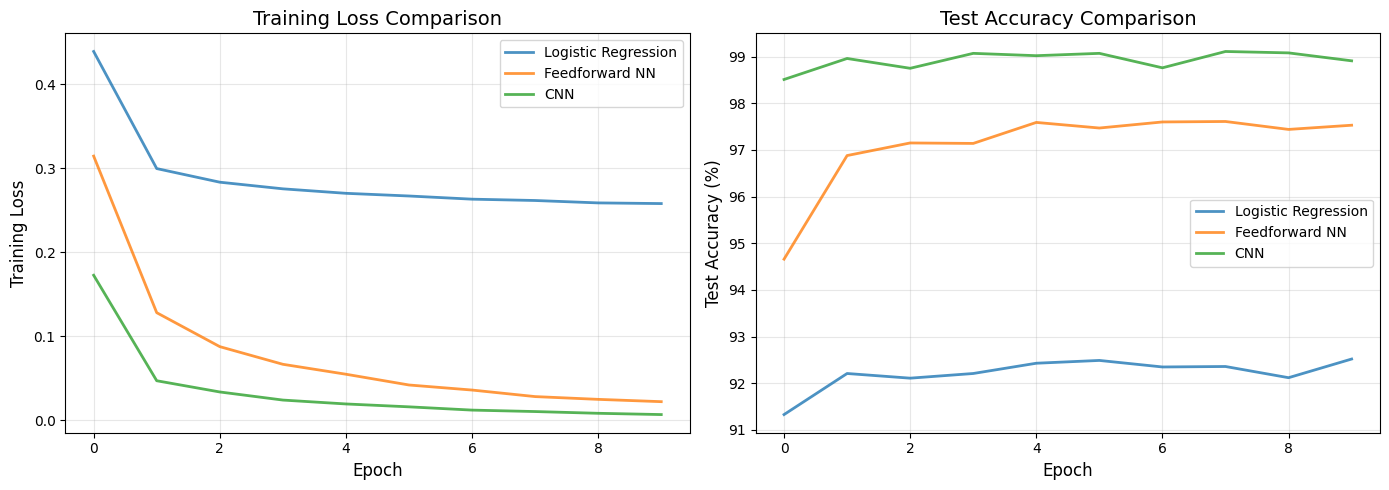

In [25]:
# Plot comparison of all three models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training loss comparison
axes[0].plot(lr_losses, label='Logistic Regression', linewidth=2, alpha=0.8)
axes[0].plot(ff_losses, label='Feedforward NN', linewidth=2, alpha=0.8)
axes[0].plot(cnn_losses, label='CNN', linewidth=2, alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Training Loss Comparison', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test accuracy comparison
axes[1].plot(lr_test_accs, label='Logistic Regression', linewidth=2, alpha=0.8)
axes[1].plot(ff_test_accs, label='Feedforward NN', linewidth=2, alpha=0.8)
axes[1].plot(cnn_test_accs, label='CNN', linewidth=2, alpha=0.8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[1].set_title('Test Accuracy Comparison', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [28]:
# Print final comparison table
print("\n" + "="*70)
print("FINAL RESULTS COMPARISON".center(70))
print("="*70)
print(f"{'Model':<30} {'Parameters':<15} {'Test Accuracy':<15}")
print("-"*70)

models_info = [
    ("Logistic Regression", sum(p.numel() for p in logistic_model.parameters()), lr_test_accs[-1]),
    ("Feedforward Neural Network", sum(p.numel() for p in feedforward_model.parameters()), ff_test_accs[-1]),
    ("Convolutional Neural Network", sum(p.numel() for p in cnn_model.parameters()), cnn_test_accs[-1])
]

for name, params, acc in models_info:
    print(f"{name:<30} {params:<15,} {acc:<15.2f}%")

print("="*70)



                       FINAL RESULTS COMPARISON                       
Model                          Parameters      Test Accuracy  
----------------------------------------------------------------------
Logistic Regression            7,850           92.52          %
Feedforward Neural Network     109,386         97.53          %
Convolutional Neural Network   421,642         98.91          %


### Sample Predictions

Let's visualize some predictions from each model to see how they perform on individual examples.


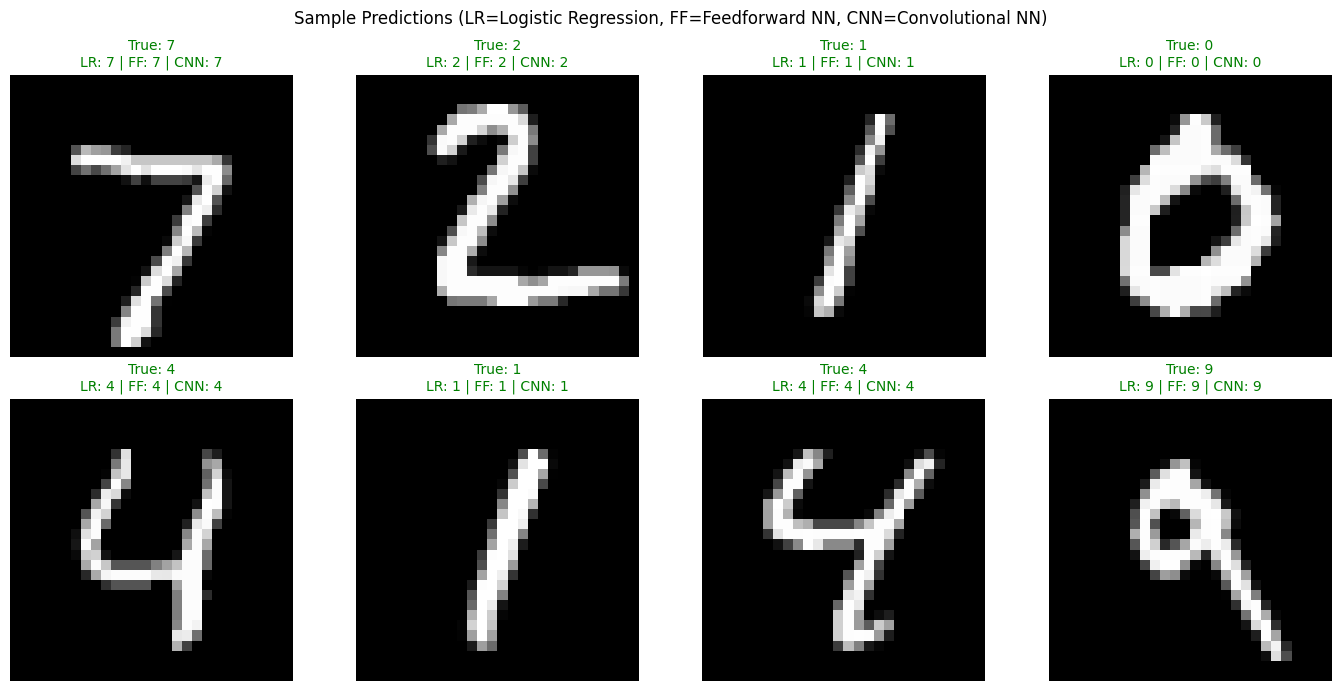

In [27]:
# Get a batch of test images
test_images, test_labels = next(iter(mnist_test_loader))
test_images, test_labels = test_images.to(device), test_labels.to(device)

# Get predictions from all three models
logistic_model.eval()
feedforward_model.eval()
cnn_model.eval()

with torch.no_grad():
    lr_outputs = logistic_model(test_images)
    ff_outputs = feedforward_model(test_images)
    cnn_outputs = cnn_model(test_images)

    _, lr_preds = torch.max(lr_outputs, 1)
    _, ff_preds = torch.max(ff_outputs, 1)
    _, cnn_preds = torch.max(cnn_outputs, 1)

# Visualize 8 examples
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for i, ax in enumerate(axes.flat):
    # Get image and denormalize for visualization
    img = test_images[i].cpu().squeeze().numpy() * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')

    true_label = test_labels[i].item()
    lr_pred = lr_preds[i].item()
    ff_pred = ff_preds[i].item()
    cnn_pred = cnn_preds[i].item()

    # Color code: green if all correct, yellow if some correct, red if all wrong
    all_correct = (lr_pred == true_label and ff_pred == true_label and cnn_pred == true_label)
    all_wrong = (lr_pred != true_label and ff_pred != true_label and cnn_pred != true_label)

    color = "green" if all_correct else "red" if all_wrong else "orange"

    title = f"True: {true_label}\n"
    title += f"LR: {lr_pred} | FF: {ff_pred} | CNN: {cnn_pred}"

    ax.set_title(title, fontsize=10, color=color)
    ax.axis("off")

plt.suptitle("Sample Predictions (LR=Logistic Regression, FF=Feedforward NN, CNN=Convolutional NN)",
             fontsize=12)
plt.tight_layout()
plt.show()


### Summary: When Neural Networks Excel

This MNIST comparison clearly demonstrates when and why neural networks outperform traditional machine learning:

#### Breast Cancer (Previous Section) vs MNIST Comparison:

| Dataset Feature | Breast Cancer | MNIST |
|----------------|---------------|-------|
| **Samples** | 569 | 70,000 |
| **Features** | 30 (engineered) | 784 (raw pixels) |
| **Feature Engineering** | Pre-computed statistics | None - raw data |
| **Relationships** | Mostly linear | Highly non-linear |
| **Logistic Regression** | ~97% | ~92% |
| **Neural Network** | ~97% | ~98-99% |
| **NN Advantage** | Minimal | **Clear (~6-7%)** |

#### Key Takeaways:

1. **Feature Engineering Matters**: 
   - Breast cancer has carefully engineered features (mean radius, texture, etc.)
   - MNIST has raw pixels - models must learn features themselves
   - Neural networks excel at **automatic feature learning**

2. **Data Complexity**:
   - Linear models work well for simple, well-engineered features
   - Neural networks shine with complex, high-dimensional raw data
   - CNNs are specifically designed for spatial/image data

3. **When to Use Each Model**:
   - **Logistic Regression**: Small datasets, engineered features, interpretability needed
   - **Feedforward NN**: Non-linear patterns, moderate-sized data
   - **CNN**: Image/spatial data, large datasets, when accuracy is paramount

4. **The Deep Learning Revolution**:
   - Before deep learning: Required extensive manual feature engineering
   - With deep learning: Models learn features automatically from raw data
   - This is why neural networks transformed computer vision, NLP, and other fields!

#### Trade-offs:

| Model Type | Accuracy | Interpretability | Training Time | Parameters |
|-----------|----------|------------------|---------------|------------|
| Logistic Regression | Lower | High | Fast | Fewest |
| Feedforward NN | Medium | Low | Medium | Many |
| CNN | Highest | Lowest | Slower | More |

**Bottom Line**: Use the simplest model that achieves your accuracy requirements. For raw image data or complex patterns, neural networks (especially CNNs) are essential.


## Summary

In this notebook, we've covered:

1. **Backpropagation Theory**: Understanding how gradients flow backward through the network using the chain rule
2. **Manual Implementation**: Implementing backpropagation and gradient descent from scratch
3. **Training Process**: Iteratively updating weights to minimize loss and improve predictions
4. **PyTorch Implementation**: Building and training the same network using modern deep learning tools

### Key Takeaways

- **Backpropagation** efficiently computes gradients by applying the chain rule backward through the network
- **Gradient descent** uses these gradients to iteratively update parameters in the direction that reduces loss
- **Binary cross-entropy loss** is the standard loss function for binary classification
- **PyTorch** automates the backpropagation process and provides GPU acceleration and rich tools
- Both manual and PyTorch implementations achieve similar performance, validating our understanding

### Manual vs PyTorch: When to Use Each

**Manual Implementation** (almost never used):
- Educational purposes (understanding how things work)
- Research on novel architectures or training algorithms
- Full control over every detail

**PyTorch** (or other frameworks):
- Production systems (faster development, better maintenance)
- Complex architectures (automatic differentiation is invaluable)
- GPU acceleration (essential for large-scale problems)
- Industry best practices (optimized implementations)
